# ECCO v4: LLC exchanges
Exchange data across the tile faces in ECCOv4 using xgcm.

In [1]:
import numpy as np
import xarray as xr

from xmitgcm import open_mdsdataset
import xgcm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.sel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

### Load datasets

In [3]:
ds = open_mdsdataset('/rigel/ocp/users/jt2796/ECCO_v4_r2/run_budg3d_1yr/',
                     delta_t=3600, ref_date='1991-12-15 12:0:0', geometry='llc',
                     prefix=['monave2d','monave3d'])

/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xmitgcm-0.2.1-py2.7.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


### Grid dimensions

In [4]:
rA = ds.rA.load()
drF = ds.drF.load()
hFacC = ds.hFacC.load()

In [5]:
# Volume (m^3)
vol = (rA*drF*hFacC).transpose('face','k','j','i')

### Salinity (Scalar)

In [6]:
SALT = ds.SALT.load()

### Advective Flux of Salinity (Vector)

In [7]:
ADVx_SLT = ds.ADVx_SLT.load()
ADVy_SLT = ds.ADVy_SLT.load()
ADVr_SLT = ds.ADVr_SLT.load()

### Creating the grid object

In [8]:
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

In [9]:
grid = xgcm.Grid(ds, face_connections=face_connections)

In [10]:
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (90) --> left
  * left     j_g (90) --> center
X Axis (periodic):
  * center   i (90) --> left
  * left     i_g (90) --> center
Z Axis (periodic):
  * center   k (50) --> left
  * left     k_l (50) --> center
  * outer    k_p1 (51) --> center
  * right    k_u (50) --> center
T Axis (periodic):
  * center   time (12)

### `grid.diff()` for scalar

In [11]:
SALT_diffx = grid.diff(SALT, 'X')
SALT_diffy = grid.diff(SALT, 'X')

In [12]:
plt.rcParams['figure.figsize'] = 12, 8

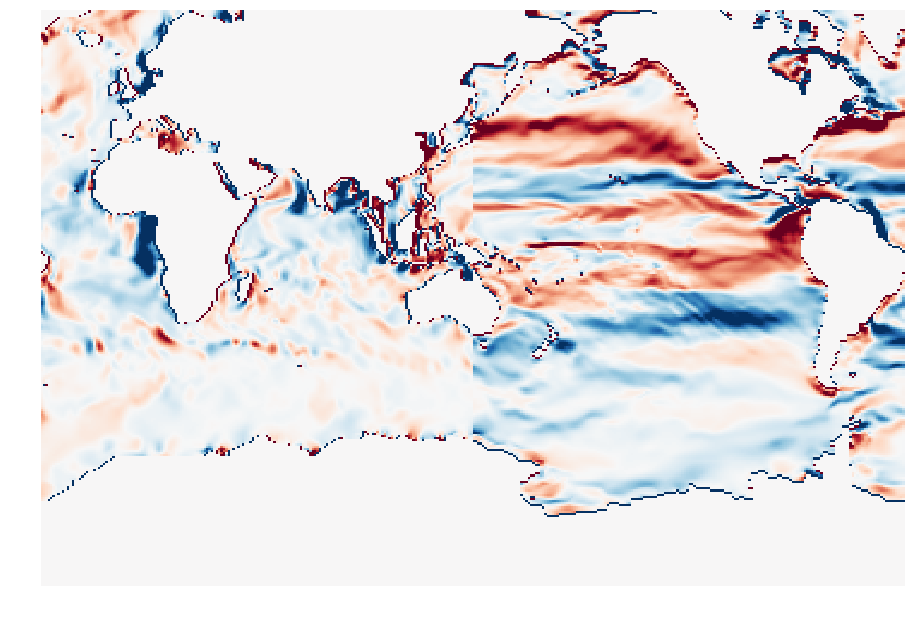

In [17]:
quick_llc_plot(SALT_diffx[1,0], add_colorbar=False, axis_off=True,
               cmap='RdBu_r', vmin=-0.2, vmax=0.2)

In [18]:
tiles = SALT_diffx[1,0]

In [19]:
tile_order = np.array([-1, -1, 10, 11, 12, \
                       -1, 6, 7, 8, 9, \
                       2, 5, -1, -1, -1, \
                       1, 4, -1, -1, -1, \
                       0, 3, -1, -1, -1])

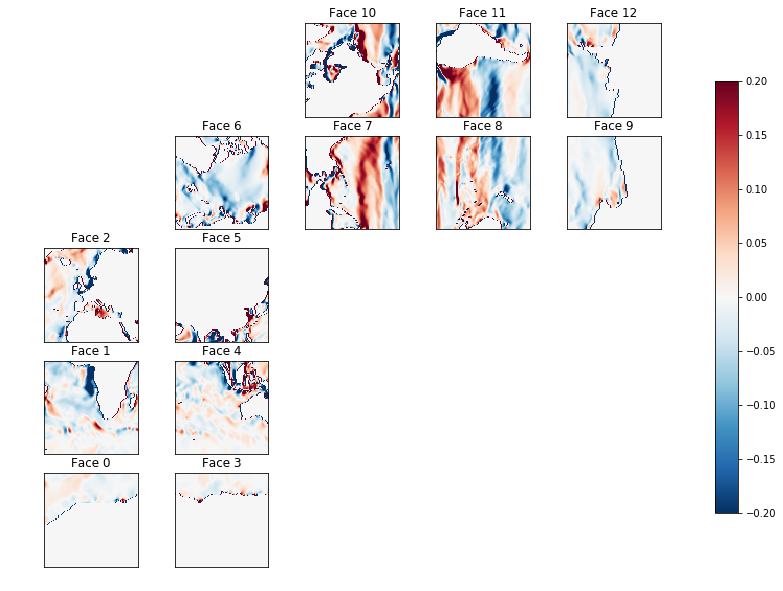

In [20]:
f, axarr = plt.subplots(5,5, figsize=(13,10))

# loop through the axes array and plot tiles where tile_order != -1
for i, ax in enumerate(axarr.ravel()):
    ax.axis('off')
    cur_tile_num = tile_order[i]
    have_tile = False
    
    if cur_tile_num >= 0:
        if type(tiles) == np.ndarray:

            if tiles.shape[0] >= cur_tile_num -1:
                have_tile = True
                cur_tile = tiles[cur_tile_num -1]
                
        else:
            if cur_tile_num in tiles.face.values:
                have_tile = True
                cur_tile = tiles.sel(face=cur_tile_num)

        if have_tile:
            im=ax.imshow(cur_tile, vmin=-0.2, vmax=0.2, cmap='RdBu_r', origin='lower')
            
        ax.set_aspect('equal')
        ax.axis('on')
        ax.set_title('Face ' + str(cur_tile_num))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
# show the colorbar
f.subplots_adjust(left=None, bottom=None, right=0.8)
#[left, bottom, width, height]
h=.6;w=.025
cbar_ax = f.add_axes([0.85, (1-h)/2, w, h])
cbar = f.colorbar(im, cax=cbar_ax)#, format='%.0e')        
#cbar.set_label(cbar_label)

### `grid.diff()` for vector

In [21]:
ADVx_SLT_diffx = grid.diff(ADVx_SLT, 'X')

ValueError: 'j_g' not found in array dimensions ('time', 'k', 'face', 'j', 'i_g')